This notebook contains calculation of DR as well as related analysis. (except of DR of co-localization modules)

In [10]:
import scanpy as sc
import numpy as np
from spatial_funcs import *
import os
from skimage.measure import regionprops
import tifffile
from scipy.stats import *

# Inputs

In [2]:
# paths
fpath = 'Z:/Data/Analyzed/2022-02-02-Hu-Hela_FUCCI'
rpath = 'Z:/Connie/RIBOmap/result/FUCCI data'

In [ ]:
# adata, genes
sample = 'ribomap'
adata = sc.read_h5ad(rpath+'/adata/FUCCI_{}_cc_02-22-22.h5ad'.format(sample))
genes = adata.var.index
genesToIndex = genes_to_index(genes)

In [3]:
# points, bases
genes2seqs, seqs2genes = load_genes(fpath)
mat_bases, mat_points = load_reads_3D(os.path.join(fpath, 'merged_spots', sample), 'merged_goodPoints_max3d.mat')
points = mat_points.astype(int)
bases = np.array([seqs2genes[x] for x in mat_bases])

Number of reads: 3107821


In [ ]:
# segmentation
cell_seg = tifffile.imread(os.path.join(fpath, 'segmentation', sample, 'cell.tif'))
nuclei_seg = tifffile.imread(os.path.join(fpath, 'segmentation', sample, 'nuclei.tif'))

In [ ]:
# region props
rp = regionprops(cell_seg)

# DR calculation

In [ ]:
# calculate DR and save in array
cells = adata[adata.obs['pass_all_filters']].obs['orig_index']
cell_by_barcode = np.zeros((len(cells), len(genes)), dtype=object) # allowing entries of diff lengths
reads_assign_cell = cell_seg[points[:,0], points[:,1], points[:,2]]
reads_assign_nucleus = nuclei_seg[points[:,0], points[:,1], points[:,2]]
for i, cell in enumerate(tqdm(cells)):
    cell_iter_cont_all(rp, cell, i, nuclei_seg, points, bases, reads_assign_cell, reads_assign_nucleus, cell_by_barcode, genesToIndex)
# np.save('DR_{}_02-23.npy'.format(sample), cell_by_barcode)

In [ ]:
# add to AnnData
for sample in ['ribomap', 'starmap']:
    # adata and DR results
    adata_cc = sc.read_h5ad(rpath+'/adata/FUCCI_{}_cc_02-22-22.h5ad'.format(sample))
    DR = np.load(rpath+'/DR/DR_{}_02-23.npy'.format(sample), allow_pickle=True)
    dr_layer = np.zeros(adata_cc.X.shape)

    c_filtered = 0 # counter -- double # check after iters
    for c in range(adata_cc.X.shape[0]):
        if adata_cc.obs.iloc[c]['pass_all_filters']:
            for g in range(adata_cc.X.shape[1]):
                if type(DR[c_filtered,g]) == list:
                    dr_layer[c,g] = np.average(DR[c_filtered,g])
                else: dr_layer[c,g] = np.nan
            c_filtered += 1
        ## for cells excluded -- all nan's
        else: dr_layer[c] = np.nan
    adata_cc.layers['avgDR'] = dr_layer
    # break
    # adata_cc.write_h5ad('FUCCI_{}_cc_dr_02-24-22.h5ad'.format(sample))

# Analysis using DR

In [6]:
# import dr result
adata_DR = dict()
gene_DR = dict()
for sample in ['ribomap', 'starmap']:
    dr = sc.read_h5ad(rpath+'/adata/FUCCI_{}_cc_dr_02-24-22.h5ad'.format(sample))
    gene_dr = np.nanmean(dr.layers['avgDR'], axis=0)
    adata_DR[sample] = dr
    gene_DR[sample] = gene_dr

In [41]:
# coding non-coding
coding_info = pd.read_excel('Z:/Connie/RIBOmap/gene_modules/TEMPOmap non-coding RNA.xlsx')
coding_genes = coding_info[coding_info['Non-coding RNA']==0]['Gene'].values # 988
genes_coding = genes[np.isin(genes, coding_genes)] # 981

## STARmap vs RIBOmap

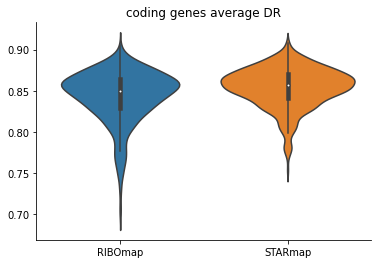

In [14]:
# compare RIBOmap STARmap
sns.violinplot(data=[gene_DR['ribomap'][np.isin(genes, coding_genes)], gene_DR['starmap'][np.isin(genes, coding_genes)]]).set_xticklabels(['RIBOmap', 'STARmap'])
plt.title('coding genes average DR')
sns.despine()
# plt.savefig(rpath+'/figures/DR/coding_genes.pdf')

In [15]:
# wilcoxon signed-rank
wilcoxon(x=gene_DR['ribomap'][np.isin(genes, coding_genes)], y=gene_DR['starmap'][np.isin(genes, coding_genes)])

WilcoxonResult(statistic=113109.0, pvalue=6.050356741120428e-47)

In [38]:
df = pd.DataFrame(zip(gene_DR['ribomap'][np.isin(genes, coding_genes)], gene_DR['starmap'][np.isin(genes, coding_genes)]), columns=['RIBOmap', 'STARmap'])
df['delta'] = df['RIBOmap'] - df['STARmap']
df['color'] = ['#28F46F' if abs(i) >=0.02 else '#AFE2C1' for i in df['delta']]
df

,RIBOmap,STARmap,delta,color
0,0.860920,0.867028,-0.006108,#AFE2C1
1,0.859694,0.825158,0.034535,#28F46F
2,0.877000,0.878105,-0.001104,#AFE2C1
3,0.705526,0.786604,-0.081078,#28F46F
4,0.894733,0.862024,0.032709,#28F46F
...,...,...,...,...
976,0.846169,0.874602,-0.028432,#28F46F
977,0.841249,0.880545,-0.039296,#28F46F
978,0.827800,0.841591,-0.013792,#AFE2C1
979,0.829915,0.845062,-0.015147,#AFE2C1


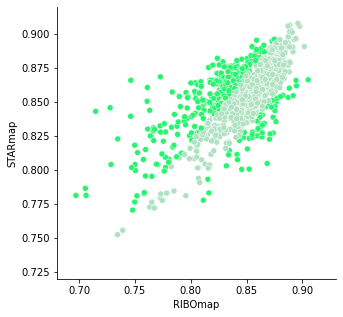

In [39]:
plt.figure(figsize=(5,5))
ax = sns.scatterplot(data=df, x='RIBOmap', y='STARmap', c=df['color'])
# plt.axline((1, 1), slope=1,color='red',ls="--")
plt.xlim(0.68,0.93)
plt.ylim(0.72,0.92)
ax.set_xlabel('RIBOmap'), ax.set_ylabel('STARmap')
sns.despine()
# plt.savefig(rpath+'/figures/DR/ribo-star.pdf')

## m6A

In [40]:
# compare m6A, non-m6A, no-labels
m6A_info = pd.read_excel('Z:/Connie/RIBOmap/gene_modules/m6A new label.xlsx')
m6A_genes = m6A_info[m6A_info['m6A label']=='m6A']['Gene'].values 
non_m6A_genes = m6A_info[m6A_info['m6A label']=='non m6A']['Gene'].values
unlabeled_m6A_genes = genes[np.isin(genes, np.concatenate((m6A_genes, non_m6A_genes)))]

In [42]:
# add m6A info onto xlsx for Hu
m6A_label = []
for g in genes:
    if g in m6A_genes:
        m6A_label.append('m6A')
    elif g in non_m6A_genes:
        m6A_label.append('non m6A')
    else: m6A_label.append('no labels')
# with pd.ExcelWriter(rpath+'/FUCCI_expr_dr.xlsx', mode='a', engine='openpyxl') as writer:
#     pd.DataFrame(m6A_label).to_excel(writer, sheet_name='m6A label')
m6A_label = np.array(m6A_label)

In [43]:
# for sns plotting (coding genes only)
df = pd.DataFrame(np.concatenate((np.concatenate((genes_coding, genes_coding)).reshape(-1,1), 
                np.concatenate((['RIBOmap']*len(genes_coding), ['STARmap']*len(genes_coding))).reshape(-1,1), 
                np.concatenate((m6A_label[np.isin(genes, coding_genes)], m6A_label[np.isin(genes, coding_genes)])).reshape(-1,1),
                np.concatenate((gene_DR['ribomap'][np.isin(genes, coding_genes)], gene_DR['starmap'][np.isin(genes, coding_genes)])).reshape(-1,1)), 
                axis=1), columns=['gene', 'tech', 'm6A', 'value'])
df['value'] = df['value'].astype(float)

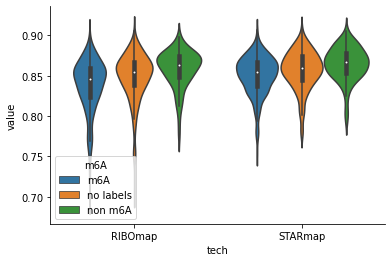

In [44]:
sns.violinplot(data=df, x='tech', y='value', hue='m6A')
sns.despine()
# plt.savefig(rpath+'/figures/DR/m6A.pdf')

### cell cycle

In [45]:
sample_dr_cc = []
gene_by_cc = []
for sample in ['ribomap', 'starmap']:
    dr_layer = adata_DR[sample].layers['avgDR']
    for cc in ['G1', 'S', 'G2M']:
        cc_dr = dr_layer[adata_DR[sample].obs['phase_new']==cc]
        gene_cc_dr = np.nanmean(cc_dr, axis=0)
        gene_cc_dr = gene_cc_dr[np.isin(genes, coding_genes)]
        gene_by_cc.append(gene_cc_dr)
        sample_dr_cc.extend(list(gene_cc_dr))

In [46]:
# violin plot -- need: df of gene, tech, cc, value
df_cc = pd.DataFrame(np.concatenate((np.array(list(genes_coding)*6).reshape(-1,1), 
                                    np.concatenate((['RIBOmap']*len(genes_coding)*3, ['STARmap']*len(genes_coding)*3)).reshape(-1,1), 
                                    np.tile(np.repeat(['G1', 'G1S', 'G2M'], len(genes_coding)), 2).reshape(-1,1),
                                    np.array(sample_dr_cc).reshape(-1,1)), 
                                axis=1), columns=['gene', 'tech', 'cc', 'value'])

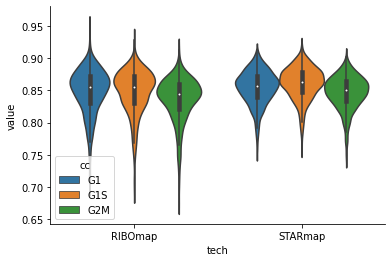

In [47]:
df_cc['value'] = df_cc['value'].astype(float)
sns.violinplot(data=df_cc, x='tech', y='value', hue='cc')
sns.despine()
# plt.savefig(rpath+'/figures/DR/cell_cycle.pdf')

In [48]:
# scatter plot -- need: gene_by_cc
df_genecc = pd.DataFrame(np.array(gene_by_cc).T, columns=['RIBOmap_G1', 'RIBOmap_G1S', 'RIBOmap_G2M', 'STARmap_G1', 'STARmap_G1S', 'STARmap_G2M'])

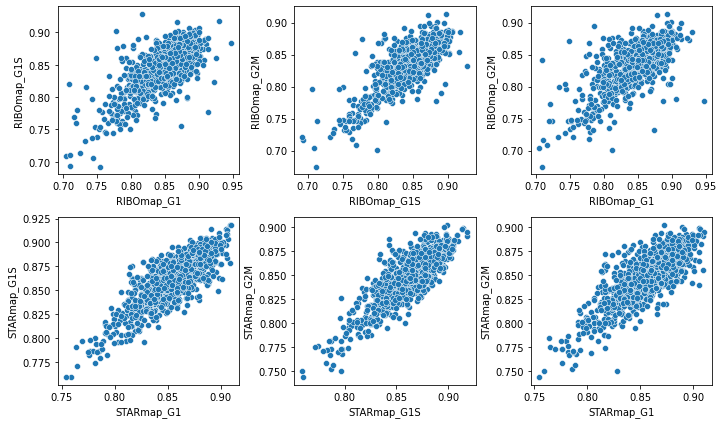

In [49]:
fig, ax = plt.subplots(2,3,figsize=(10,6))
for i, sample in enumerate(['RIBOmap', 'STARmap']):
    sns.scatterplot(x=df_genecc[sample+'_G1'], y=df_genecc[sample+'_G1S'], ax=ax[i,0])
    sns.scatterplot(x=df_genecc[sample+'_G1S'], y=df_genecc[sample+'_G2M'], ax=ax[i,1])
    sns.scatterplot(x=df_genecc[sample+'_G1'], y=df_genecc[sample+'_G2M'], ax=ax[i,2])
plt.tight_layout()
# fig.savefig(rpath+'/figures/DR/cc_correlation.pdf')

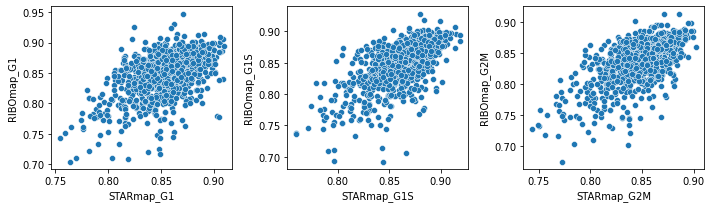

In [50]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
sns.scatterplot(x=df_genecc['STARmap_G1'], y=df_genecc['RIBOmap_G1'], ax=ax[0])
sns.scatterplot(x=df_genecc['STARmap_G1S'], y=df_genecc['RIBOmap_G1S'], ax=ax[1])
sns.scatterplot(x=df_genecc['STARmap_G2M'], y=df_genecc['RIBOmap_G2M'], ax=ax[2])
plt.tight_layout()
# fig.savefig(rpath+'/figures/DR/ribo-star-cc.pdf')